# Evaluating the CollaGAN model that has palette quantization inside it (proposed for ENTCON"25)

We adapted the CollaGAN model from SBGames"24 to always produce images that follow an input palette. This is done through a differential palette quantization layer we proposed for ENTCON"25.

We want to evaluate both numerically and visually if by having the palette quantization inside the network improves the quality of the generated images when compared: (a) to not using it (the SBGames"24 baseline) and (b) to using it as a post-process step (proposed in GMOD"24).


In [1]:
import logging_utils

import tensorflow as tf

# USES ALL 4GB VRAM of my GeForce GTX 1050 Ti
# COMMENT THE FOLLOWING LINES TO USE THE DEFAULT VRAM
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]
    )
# end of the VRAM usage configuration



from ModelProxy import CollaGANModelProxy

logging_utils.configure()

model_loaders = {
    "collagan": lambda: CollaGANModelProxy("models/collagan-entcon/original-generator", palette_input=False, post_process=False, is_legacy_tf_saved_model=True, domain_dtype="int32"),
    "collagan-post-process": lambda: CollaGANModelProxy("models/collagan-entcon/original-generator", palette_input=False, post_process=True, is_legacy_tf_saved_model=True, domain_dtype="int32"),
    "collagan-palette-no-coverage": lambda: CollaGANModelProxy("models/collagan-entcon/lambda-palette-0.0", palette_input=True, post_process=False, is_legacy_tf_saved_model=False, domain_dtype="int32"),
    "collagan-palette": lambda: CollaGANModelProxy("models/collagan-entcon/lambda-palette-1.0", palette_input=True, post_process=False, is_legacy_tf_saved_model=False, domain_dtype="int32"),
}

2025-05-30 14:27:58.323481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-30 14:27:58.354397: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-30 14:27:58.354444: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-30 14:27:58.376567: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-30 14:27:59.920233: W tensorflow/compiler/tf

## Loads the Larger Dataset

These tests use the Larger dataset.


In [2]:
from dataset_utils import DatasetLoader


dataset_loader = DatasetLoader("all", "test", limit=None)


## Generates Images for a Qualitative Analysis


In [3]:
import tensorflow as tf

def generate_batch_with_each_source_combination(model_name, number_of_4batches=1, sample_numbers=None):
    mode = "random_batch" if sample_numbers is None else "specific_samples"
    batch_transpose = None
    if mode == "specific_samples":
        batch = [dataset_loader.load_paired_images(sample_number) for sample_number in sample_numbers]
        batch = tf.stack(batch, axis=0)
        batch_transpose = batch
    elif mode == "random_batch":
        # loads a batch of images
        batch = next(iter(dataset_loader.dataset.shuffle(600).batch(number_of_4batches*4).take(1)))
        batch_transpose = tf.transpose(batch, [1, 0, 2, 3, 4])

    genned_images = []
    target_indices = tf.repeat(tf.range(0, 4), [number_of_4batches] * 4)
    target_images = tf.gather(batch_transpose, target_indices, batch_dims=1)
    # loads the model into memory
    generator = model_loaders[model_name]()
    input_situation_numbers = [1, 2, 3]
    input_situation_names = [f"CollaGAN-{n}" for n in input_situation_numbers]
    for situation_name, input_number in zip(input_situation_names, input_situation_numbers):
        # generates the images
        if input_number in [1, 2]:
            # there are 3 images to be generated, in a 2x2 sub-figure
            fake_images = []
            for sample_idx, target_domain in enumerate(target_indices):
                fake_images_of_example = []
                for source_domain in range(4):
                    if source_domain == target_domain:
                        single_fake_image = tf.ones_like(target_images[0])[tf.newaxis, ...] * -1.
                    else:
                        # print("Generating", situation_name, "images for source", source_domain, "and target", target_domain)
                        if input_number == 1:
                            dropped_mask = tf.constant([1 if i == source_domain else 0 for i in range(4)], dtype=tf.float32)
                            source_images = batch_transpose[sample_idx] * dropped_mask[..., tf.newaxis, tf.newaxis, tf.newaxis]
                        elif input_number == 2:
                            dropped_mask = tf.constant([0 if i == target_domain or i == source_domain else 1 for i in range(4)], dtype=tf.float32)
                            source_images = batch_transpose[sample_idx] * dropped_mask[..., tf.newaxis, tf.newaxis, tf.newaxis]
                        # print("...hence, dropped_mask is", dropped_mask.numpy(), "and source_images shape is", source_images.shape)
                        # print("source_images" ,source_images)
                        single_fake_image = generator.generate_from_multiple(target_domain[tf.newaxis, ...], source_images[tf.newaxis, ...])
                    fake_images_of_example += [single_fake_image]
                fake_images_of_example = tf.concat(fake_images_of_example, axis=0)
                fake_images += [fake_images_of_example]
            fake_images = tf.stack(fake_images, axis=0)

        else:
            # there is only one image to be generated, as all source images are used
            dropped_mask = tf.one_hot(target_indices, 4, dtype=tf.float32, off_value=1.0, on_value=0.0)
            source_images = batch_transpose * dropped_mask[..., tf.newaxis, tf.newaxis, tf.newaxis]
            fake_images = generator.generate_from_multiple(target_indices, source_images)

        genned_images += [fake_images]

    # frees the memory used by the model
    del generator

    # sets the target images in the source images to -1, so it becomes a checkerboard pattern when displaying
    target_in_source_mask = tf.one_hot(target_indices, 4, dtype=tf.float32)[..., tf.newaxis, tf.newaxis, tf.newaxis]
    source_images += target_in_source_mask * -1
    return source_images, target_images, genned_images, ""


starting_test_sample_numbers = stsn = {"tiny": 0, "rm2k": 136, "rmxp": 168, "rmvx": 212, "misc": 273}
example_numbers=[
    stsn["rmxp"]+25,    # rmxp maid lady
    stsn["misc"]+782,   #
    stsn["rmxp"]+4,     # rmxp bunny tiara girl
    stsn["misc"]+207,
    # stsn["misc"]+1701,  # misc tiny butt
    # stsn["rm2k"]+20,  #
    # stsn["rmxp"]+5,     # rmxp cook
    # stsn["rmvx"]+27,    # rmvx santa

    # stsn["rmvx"]+37,    # rmvx fire warlock
    # stsn["misc"]+1304,  # misc crop knight
    # stsn["rmvx"]+27,    # rmvx santa
]
# imgs_params = generate_batch_with_each_source_combination("collagan", 1, example_numbers)


In [4]:
from matplotlib import pyplot as plt
from image_utils import show_collagan_input_comparison


# f = show_collagan_input_comparison(*imgs_params)
# plt.savefig("output/collagan_palette_quantization_comparison.png", format="png", transparent=True)


## Compares CollaGAN, CollaGAN with Post-Process Palette Quantization, and CollaGAN with Palette Quantization Inside

Now we compare the images generated by each model, producing an image.

In [5]:
import tensorflow as tf

def generate_batch_with_each_source_combination(number_of_4batches=1, sample_numbers=None):
    mode = "random_batch" if sample_numbers is None else "specific_samples"
    if mode == "random_batch":
        # chooses number_of_4batchs*4 indices of examples to load
        sample_numbers = tf.random.uniform([number_of_4batches*4], minval=0, maxval=dataset_loader.dataset_size, dtype=tf.int32)
        # sample_numbers = tf.sort(sample_numbers)
        print("Sample numbers:", sample_numbers.numpy())
    batch = [dataset_loader.load_paired_images(sample_number) for sample_number in sample_numbers]
    batch = tf.stack(batch, axis=0)
    batch_transpose = batch

    genned_images = []
    target_indices = tf.repeat(tf.range(0, 4), [number_of_4batches] * 4)
    # target_indices = tf.repeat([1,1,3,3], [number_of_4batches] * 4)
    target_images = tf.gather(batch_transpose, target_indices, batch_dims=1)
    # loads the model into memory
    for model_name in model_loaders.keys():
        print(f"Loading {model_name}... ", end="")
        generator = model_loaders[model_name]()
        print(f"Loaded.")

        # generates the images
        dropped_mask = tf.one_hot(target_indices, 4, dtype=tf.float32, off_value=1.0, on_value=0.0)
        source_images = batch_transpose * dropped_mask[..., tf.newaxis, tf.newaxis, tf.newaxis]
        fake_images = generator.generate_from_multiple(target_indices, source_images)

        genned_images += [fake_images]

        # frees the memory used by the model
        print(f"Unloading {model_name}... ", end="")
        del generator
        print(f"Unloaded.")

    # sets the target images in the source images to -1, so it becomes a checkerboard pattern when displaying
    target_in_source_mask = tf.one_hot(target_indices, 4, dtype=tf.float32)[..., tf.newaxis, tf.newaxis, tf.newaxis]
    source_images += target_in_source_mask * -1
    return source_images, target_images, genned_images, ""


starting_test_sample_numbers = stsn = {"tiny": 0, "rm2k": 136, "rmxp": 168, "rmvx": 212, "misc": 273}
example_numbers=[
    stsn["rmxp"]+25,    # rmxp maid lady
    stsn["misc"]+782,   #
    stsn["rmxp"]+4,     # rmxp bunny tiara girl
    stsn["misc"]+207,
    # stsn["misc"]+1701,  # misc tiny butt
    # stsn["rm2k"]+20,  #
    # stsn["rmxp"]+5,     # rmxp cook
    # stsn["rmvx"]+27,    # rmvx santa

    # stsn["rmvx"]+37,    # rmvx fire warlock
    # stsn["misc"]+1304,  # misc crop knight
    # stsn["rmvx"]+27,    # rmvx santa
]

# back: 232, 1338, 1418
# left: 709, 202, 1789
# front: 1920, 1572, 1798
# right: 1316, 476, 1537
example_numbers = [
    232, 1338, 1418,
    1466, 709, 202,#, 1789,
    1920, 1572, 1798,
    1316, 1789, 1537
]
imgs_params = generate_batch_with_each_source_combination(3, example_numbers)

2025-05-30 14:28:12 WARNING  5 out of the last 5 calls to <function DatasetLoader.load_paired_images at 0x73aba77735e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2025-05-30 14:28:12 WARNING  6 out of the last 6 calls to <function DatasetLoader.load_paired_images at 0x73aba77735e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Loading collagan... Loaded.


2025-05-30 14:28:39.916550: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-05-30 14:28:43.318562: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-30 14:28:44.619087: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.48GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


Unloading collagan... Unloaded.
Loading collagan-post-process... Loaded.
Unloading collagan-post-process... Unloaded.
Loading collagan-palette-no-coverage... Loaded.
Unloading collagan-palette-no-coverage... Unloaded.
Loading collagan-palette... Loaded.
Unloading collagan-palette... Unloaded.


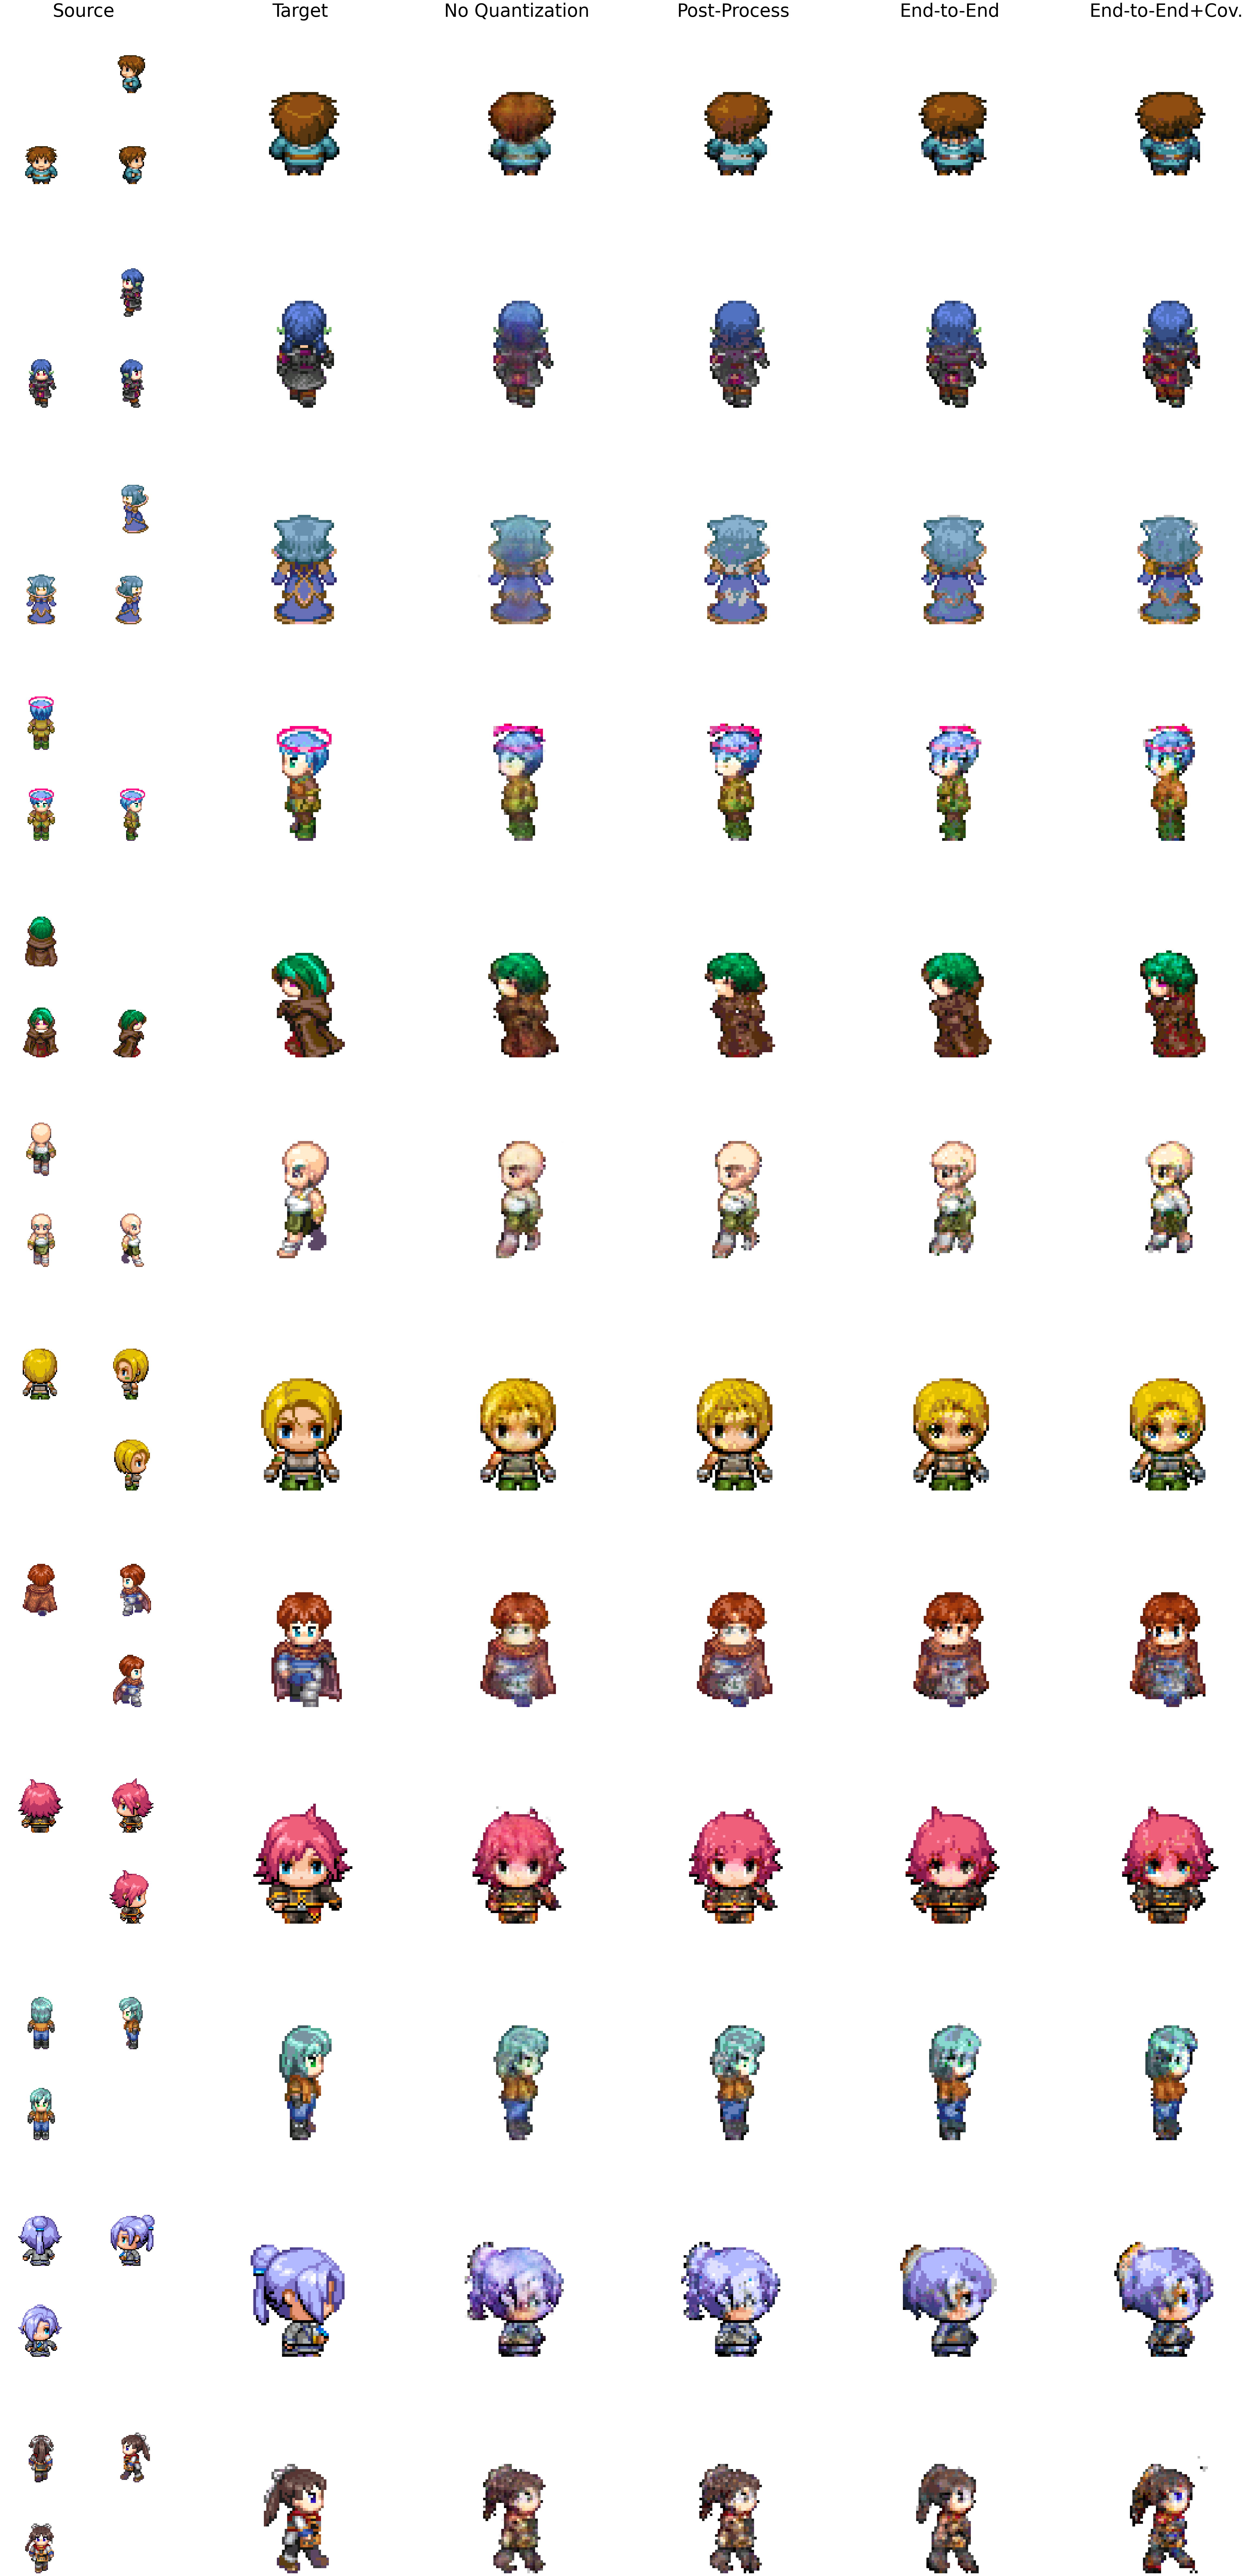

In [6]:
from image_utils import show_multiple_input_model_comparison

from matplotlib import pyplot as plt
from image_utils import show_collagan_input_comparison


f = show_multiple_input_model_comparison(*imgs_params, model_names=["No Quantization", "Post-Process", "End-to-End", "End-to-End+Cov."])
# plt.savefig("output/collagan_palette_quantization_comparison.png", format="png", transparent=True)
